# 03 — EDA Cardiovascular (manifest-driven, robust path)
Resolve `SNAPDIR` por manifests reais; ignora `data_ai/` inválidos; aceita override via `SNAPDIR` absoluto.


In [1]:

import os, json, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _read_json(p: Path):
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return None

def _find_candidate_roots(start: Path):
    """Sobe diretórios e coleta diretórios que contenham 'data_ai/' **válido** (com P*/snapshots/*/manifest)."""
    roots = []
    cur = start.resolve()
    seen = set()
    for _ in range(12):
        dai = cur/"data_ai"
        if dai.exists() and dai.is_dir():
            # validar estrutura
            has_valid = False
            for pdir in dai.glob("P*/"):
                sm = pdir/"snapshots"
                if sm.exists():
                    for sdir in sm.glob("*"):
                        if (sdir/"cardio_manifest.json").exists() or (sdir/"extract_manifest.json").exists():
                            has_valid = True; break
                if has_valid: break
            if has_valid and cur not in seen:
                roots.append(cur)
                seen.add(cur)
        if cur.parent == cur: break
        cur = cur.parent
    return roots

def _pick_best_root(candidates):
    """Escolhe root com MAIOR número de manifests válidos."""
    def count_manifests(root: Path):
        n=0
        for m in (root/"data_ai").rglob("cardio_manifest.json"):
            n+=1
        for m in (root/"data_ai").rglob("extract_manifest.json"):
            n+=1
        return n
    if not candidates: return None
    return max(candidates, key=count_manifests)

def _resolve_snapdir(repo_root: Path, pid: str|None, snap: str|None):
    # 1) override absoluto por env SNAPDIR
    env_sd = os.getenv("SNAPDIR")
    if env_sd:
        p = Path(env_sd)
        if p.exists():
            return p

    # 2) se pid+snap dados, usar direto
    if pid and snap:
        sd = repo_root/"data_ai"/pid/"snapshots"/snap
        if sd.exists(): return sd

    # 3) procurar manifest com features_cardio existente
    dai = repo_root/"data_ai"
    best = None
    for pdir in sorted(dai.glob("P*/")):
        for sdir in sorted((pdir/"snapshots").glob("*")):
            cm = sdir/"cardio_manifest.json"
            em = sdir/"extract_manifest.json"
            if cm.exists():
                m = _read_json(cm) or {}
                out = (m.get("outputs") or {})
                fcard = out.get("features_cardio", {}).get("path")
                if fcard and Path(fcard).exists():
                    return sdir
                best = best or sdir
            elif em.exists():
                best = best or sdir
    return best

# --- descobrir repo_root robusto ---
CWD = Path.cwd()
roots = _find_candidate_roots(CWD)
repo_root = _pick_best_root(roots)
# fallback: se nenhum válido, mas existe data_ai diretamente acima com P*:
if repo_root is None:
    # tolerar caso remoto: usar primeira 'data_ai' com P*
    cur=CWD.resolve()
    for _ in range(12):
        dai = cur/"data_ai"
        if dai.exists() and any(dai.glob("P*/")):
            repo_root = cur; break
        if cur.parent==cur: break
        cur=cur.parent
if repo_root is None:
    raise FileNotFoundError("Não foi possível localizar um REPO_ROOT com data_ai válido. Remova pastas 'data_ai' falsas (ex.: notebooks/data_ai).")

print("REPO_ROOT =", repo_root)

PID  = os.getenv("PID") or "P000001"
SNAP = os.getenv("SNAP") or None  # se None, usamos o primeiro snapshot válido

SNAPDIR = _resolve_snapdir(repo_root, PID, SNAP)
print("SNAPDIR =", SNAPDIR)
if SNAPDIR is None or not SNAPDIR.exists():
    raise FileNotFoundError("Snapshot não encontrado. Defina SNAPDIR absoluto via env, ou PID+SNAP, ou rode o pipeline.")

OUTDIR = SNAPDIR/"eda_outputs"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("OUTDIR  =", OUTDIR)


REPO_ROOT = C:\dev\practicum2-nof1-adhd-bd
SNAPDIR = C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29
OUTDIR  = C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\eda_outputs


In [2]:

fc_path = SNAPDIR/"features_cardiovascular.csv"
fd_path = SNAPDIR/"features_daily_updated.csv"

print("== Checagem de arquivos ==")
for p in [fc_path, fd_path, SNAPDIR/"per-metric"/"apple_heart_rate.csv",
          SNAPDIR/"per-metric"/"apple_hrv_sdnn.csv", SNAPDIR/"per-metric"/"apple_sleep_intervals.csv"]:
    print("-", p, "exists=", p.exists(), "size=", (p.stat().st_size if p.exists() else 0))

fc = None
if fc_path.exists() and fc_path.stat().st_size>0:
    fc = pd.read_csv(fc_path, parse_dates=["date"])
    fc["date"] = pd.to_datetime(fc["date"], errors="coerce")
    try:
        fc["date"] = fc["date"].dt.tz_convert("UTC").dt.tz_localize(None)
    except Exception:
        pass
    fc["date"] = fc["date"].dt.date
    print("features_cardiovascular:", fc.shape)
    display(fc.head(3))
else:
    print("⚠️  features_cardiovascular.csv ausente ou vazio:", fc_path)


== Checagem de arquivos ==
- C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\features_cardiovascular.csv exists= True size= 86605
- C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\features_daily_updated.csv exists= True size= 275884
- C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\per-metric\apple_heart_rate.csv exists= True size= 150454117
- C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\per-metric\apple_hrv_sdnn.csv exists= True size= 681
- C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\per-metric\apple_sleep_intervals.csv exists= True size= 2219109
features_cardiovascular: (1291, 9)


,date,hr_mean,hr_std,hr_min,hr_max,n_hr,hrv_ms_mean,hrv_ms_std,n_hrv
0,2021-05-14,70.228608,13.207186,43.0,124.0,783,NaN,NaN,NaN
1,2021-05-15,65.832618,12.098782,47.0,120.0,466,NaN,NaN,NaN
2,2021-05-16,68.196154,12.624104,47.0,120.0,520,NaN,NaN,NaN


Saved: C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\eda_outputs\hr_mean_daily.png


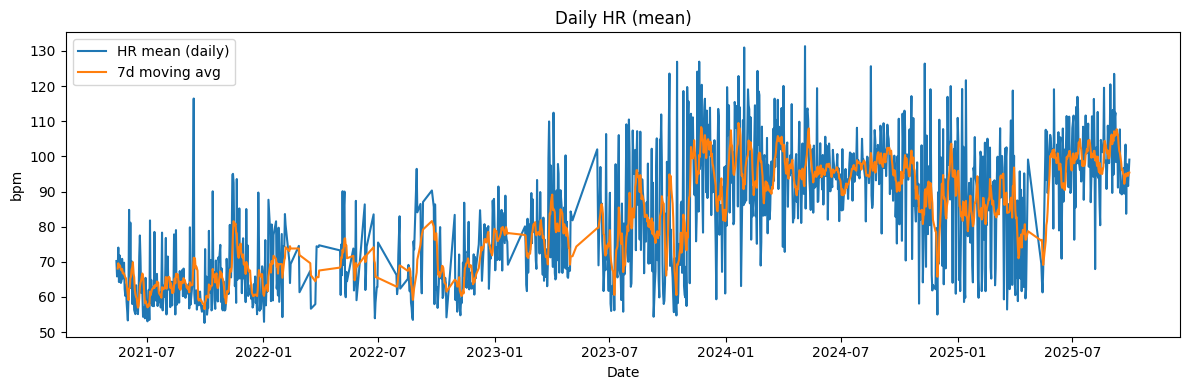

Saved: C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\eda_outputs\hist_hr_mean.png


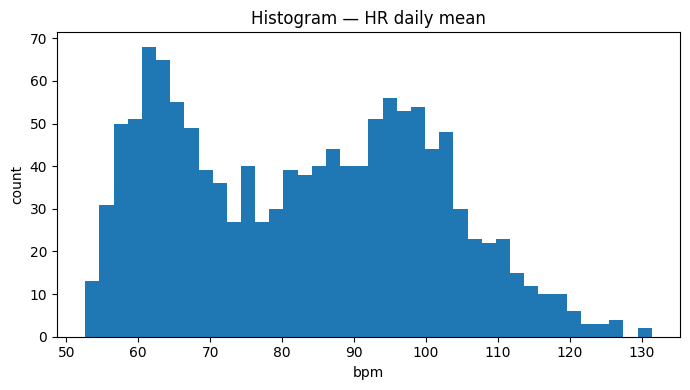

Saved: C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\eda_outputs\hrv_mean_daily.png


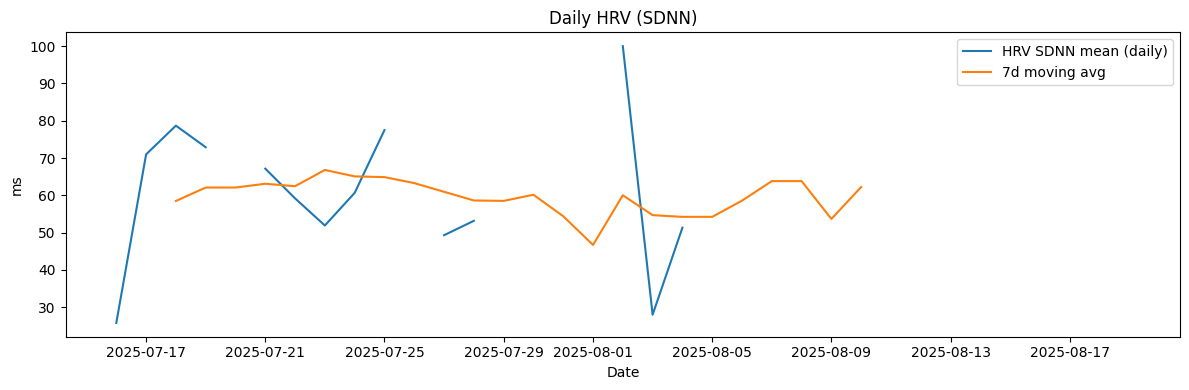

Saved: C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\eda_outputs\hist_hrv_mean.png


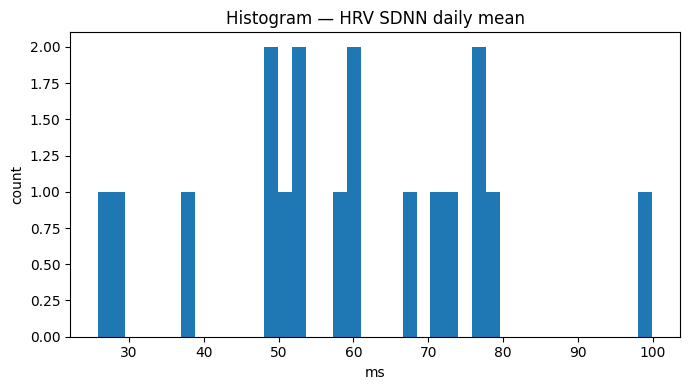

In [3]:

def _rolling7(x):
    x = pd.to_numeric(x, errors="coerce")
    return pd.Series(x).rolling(window=7, min_periods=3).mean()

if fc is not None and not fc.empty:
    # HR
    if "hr_mean" in fc.columns:
        df = fc.dropna(subset=["date"]).sort_values("date").copy()
        sdate = pd.to_datetime(df["date"])
        hr = pd.to_numeric(df["hr_mean"], errors="coerce")
        tr = _rolling7(hr)

        plt.figure(figsize=(12,4))
        plt.plot(sdate, hr, label="HR mean (daily)")
        plt.plot(sdate, tr, label="7d moving avg")
        plt.title("Daily HR (mean)")
        plt.xlabel("Date"); plt.ylabel("bpm"); plt.legend(); plt.tight_layout()
        out_png = OUTDIR/"hr_mean_daily.png"; plt.savefig(out_png); print("Saved:", out_png); plt.show()

        v = pd.to_numeric(df["hr_mean"], errors="coerce").dropna()
        if not v.empty:
            plt.figure(figsize=(7,4))
            plt.hist(v, bins=40)
            plt.title("Histogram — HR daily mean")
            plt.xlabel("bpm"); plt.ylabel("count"); plt.tight_layout()
            out_png = OUTDIR/"hist_hr_mean.png"; plt.savefig(out_png); print("Saved:", out_png); plt.show()
    else:
        print("ℹ️  Sem 'hr_mean'.")

    # HRV
    if "hrv_ms_mean" in fc.columns:
        df = fc.dropna(subset=["date"]).sort_values("date").copy()
        sdate = pd.to_datetime(df["date"])
        hv = pd.to_numeric(df["hrv_ms_mean"], errors="coerce")
        tr = _rolling7(hv)

        plt.figure(figsize=(12,4))
        plt.plot(sdate, hv, label="HRV SDNN mean (daily)")
        plt.plot(sdate, tr, label="7d moving avg")
        plt.title("Daily HRV (SDNN)")
        plt.xlabel("Date"); plt.ylabel("ms"); plt.legend(); plt.tight_layout()
        out_png = OUTDIR/"hrv_mean_daily.png"; plt.savefig(out_png); print("Saved:", out_png); plt.show()

        v = pd.to_numeric(df["hrv_ms_mean"], errors="coerce").dropna()
        if not v.empty:
            plt.figure(figsize=(7,4))
            plt.hist(v, bins=40)
            plt.title("Histogram — HRV SDNN daily mean")
            plt.xlabel("ms"); plt.ylabel("count"); plt.tight_layout()
            out_png = OUTDIR/"hist_hrv_mean.png"; plt.savefig(out_png); print("Saved:", out_png); plt.show()
    else:
        print("ℹ️  Sem 'hrv_ms_mean'.")
else:
    print("ℹ️  Sem dataframe 'fc'.")
